DSCI 100 Project

name: Ryan Cheng 

student ID: 53355756

Question to answer: 

    Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

In [12]:
# libraries / plot setting 
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.plot.width = 11, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
set.seed(4100)

# Introduction

This is a 

# Methods

In [13]:
#Read the data from the data folder
players <- read_csv("data/players.csv")|>
    as.data.frame()|>
    mutate(subscribe = as.factor(subscribe))|> # make the subscribe column a factor instead of "lgl"
     mutate(experience = case_when(
    experience == "Beginner" ~ 1,
    experience == "Amateur"  ~ 2,
    experience == "Regular"  ~ 3,
    experience == "Veteran"  ~ 4,
    experience == "Pro"      ~ 5,))#quantify the experience value 
head(players) #used head as there are too many rows


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<dbl>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,5,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,4,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,4,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,2,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,2,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [14]:
# session <- read_csv("data/session.csv")|>
#     as.data.frame()
# head(session)#not useful for this question

In order to find out which "kinds" of players are most likely to contribute a large amount of data, we need to make a model that predicts the played hours of the players. This kind of problem is a Regression problem. 

Looking at the players data, there are four varibles that can be use to do the prediction : experience, subscribe, gender, and age.

First, we need to scale the data and make some scatter plots to show the relationship between the varibles. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


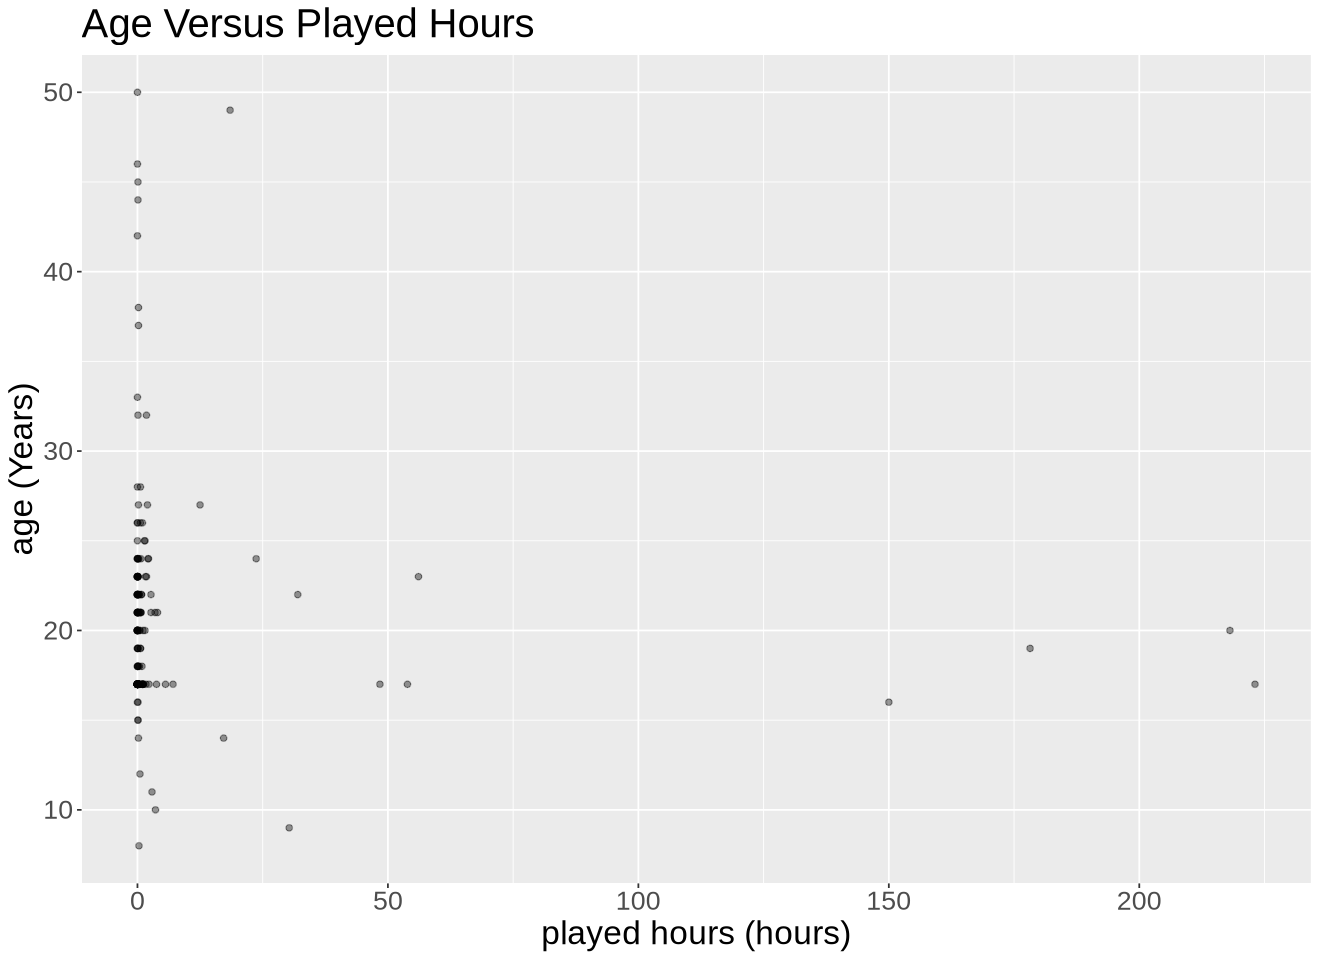

In [15]:
players_age_plot <- players|>
    ggplot(aes(x = played_hours, y = Age)) +
    geom_point(alpha = 0.4)+
    xlab("played hours (hours)")+
    ylab("age (Years)")+
    ggtitle("Age Versus Played Hours")+
theme(text = element_text(size = 20))
players_age_plot  

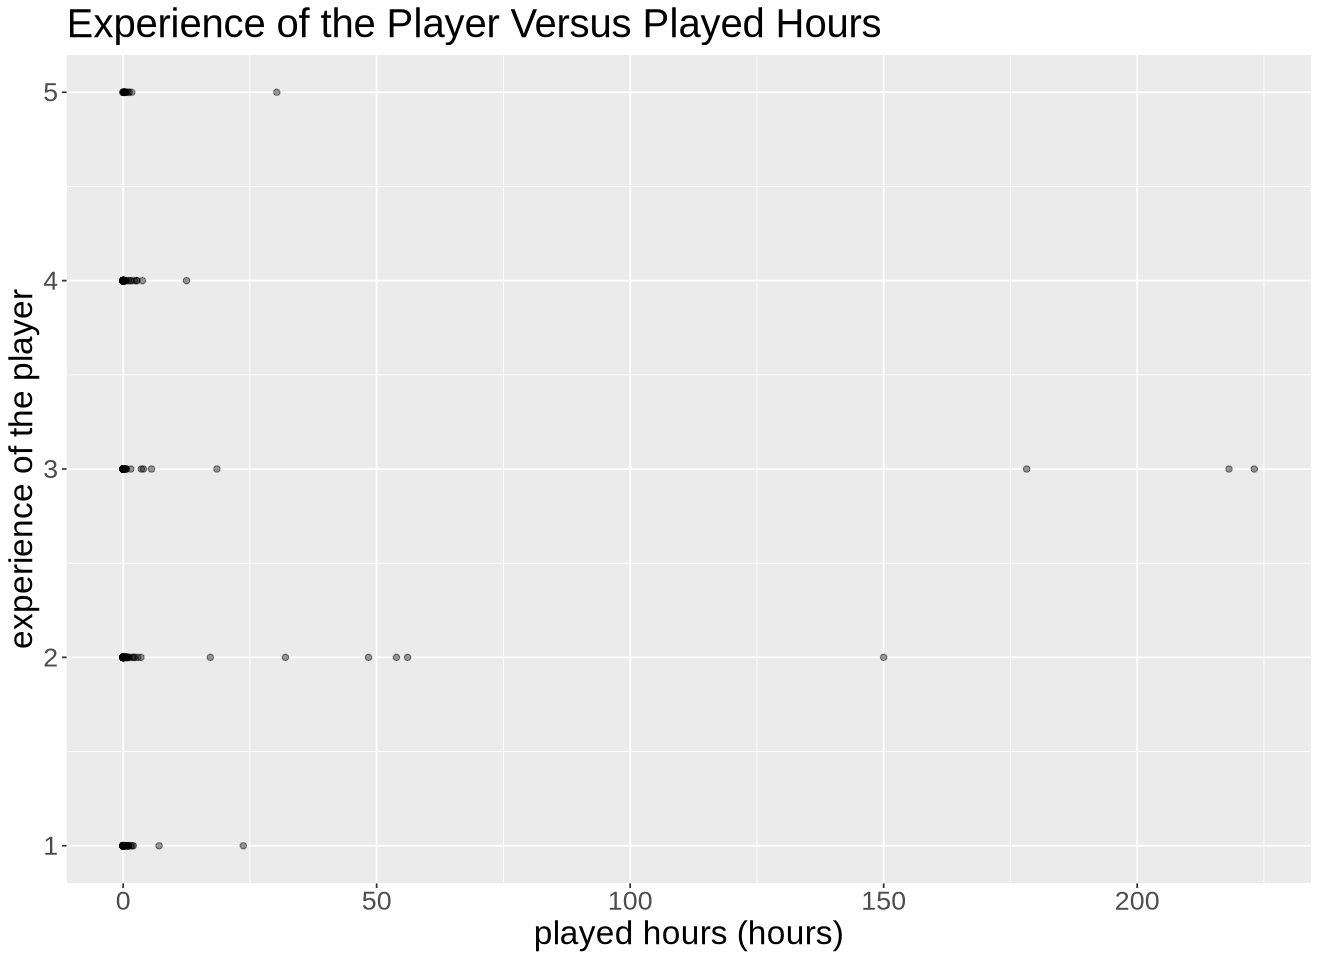

In [16]:
players_experience_plot <- players|>
    ggplot(aes(x = played_hours, y = experience)) +
    geom_point(alpha = 0.4)+
    xlab("played hours (hours)")+
    ylab("experience of the player")+
    ggtitle("Experience of the Player Versus Played Hours")+
theme(text = element_text(size = 20))
players_experience_plot  

Looking at the two plots, it doesn't seem like there is any strong linear relationship between the varibles. Thus, k-nearest neighbors regression will be used to solve this problem.  

# Model

First, we should spilt the data into a training part and a testing part. The training part will be 75% of the data and the testing part will be 25%. 

In [17]:
players_split <- initial_split(players, prop = 0.75, strata = played_hours) #spliting the players data
players_training <- training(players_split)
players_testing <- testing(players_split)

In [18]:
#create a recipe that predicts played hours with the varibles and scale the data
player_recipe <- recipe(played_hours ~ experience + Age + gender + subscribe, data = players_training)|>
    step_scale(all_of(c("experience", "Age")))|> #we cannot scale gender and subscribe
    step_center(all_of(c("experience", "Age")))
#create a model specification for k-nearest neighbors regression
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")
#use 5- fold cross validation to find the best k value
player_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

player_workflow <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec)

We will run cross validation for grid numbers of 1 to 30

In [19]:
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

player_result <- player_workflow|>
    tune_grid(resamples = player_vfold, grid = k_vals)|>
    collect_metrics()|>
     filter(.metric =="rmse")
player_result

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 29 to size 28.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,33.61827,4,9.315216,Preprocessor1_Model01
2,rmse,standard,33.90424,4,9.332638,Preprocessor1_Model02
3,rmse,standard,38.07834,4,6.492428,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,rmse,standard,32.89039,4,8.480295,Preprocessor1_Model28
29,rmse,standard,32.91232,4,8.529597,Preprocessor1_Model29
30,rmse,standard,33.02150,4,8.524160,Preprocessor1_Model30


In [20]:
player_min <- player_result|>
    filter(mean == min(mean))
player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,32.18542,4,8.142773,Preprocessor1_Model16


It seems like k = 25 will give us the lowest RMSE. 

# Result

In [21]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25)|>
    set_engine("kknn")|>
    set_mode("regression")

player_fit <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(players_spec)|>
    fit(data = players_training)

players_testing_clean <- players_testing %>% drop_na()
# preds <- predict(player_fit, players_testing_clean)
# bind_cols(preds, players_testing_clean)

player_summary <- player_fit|>
    predict(players_testing_clean)|>
    bind_cols(players_testing_clean)|>
    metrics(truth = played_hours, estimate = .pred)|>
    filter(.metric == "rmse")
player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.66226
